In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import pickle
import torch
import torch.nn as nn
import numpy as np
import tensorflow as tf
from keras.layers import Dense
import matplotlib.pyplot as plt

In [3]:
# Load the dataset from the PKL file
with open('/content/drive/MyDrive/MSA/IEMOCAP_features.pkl', 'rb') as file:
    dataset = pickle.load(file)
videoIDs, videoSpeakers, videoLabels, videoText, videoAudio, videoVisual, videoSentence, trainVid, testVid = dataset

In [4]:
video,clip = 0,0
print(f"Features in a Clip's Audio Feature: {len(videoAudio[trainVid[video]][clip])}")
print(f"Audio Feature of Clip '{videoIDs[trainVid[video]][clip]}'\n{videoAudio[trainVid[video]][clip]}")

Features in a Clip's Audio Feature: 100
Audio Feature of Clip 'Ses02F_script01_3_M001'
[0.06039171 0.         0.         0.03108024 0.         0.
 0.02215723 0.         0.04470082 0.02663268 0.         0.00755193
 0.01339373 0.04635451 0.07563031 0.         0.         0.03185713
 0.         0.         0.         0.         0.06189114 0.06663664
 0.00238679 0.0533644  0.         0.         0.         0.0283113
 0.00231764 0.06187708 0.03627795 0.05996375 0.         0.
 0.05080898 0.01523722 0.         0.05337248 0.         0.04839654
 0.         0.05178703 0.02801428 0.02576766 0.         0.
 0.         0.03630557 0.         0.00912084 0.         0.02388529
 0.         0.         0.02992127 0.         0.         0.01902505
 0.         0.00898062 0.         0.         0.         0.03700832
 0.         0.         0.03112449 0.         0.00123789 0.
 0.         0.         0.         0.03217268 0.         0.
 0.         0.03004344 0.01329944 0.         0.         0.
 0.00152095 0.03870668 0

In [15]:
# Define a simple Bi-GRU for audio data
class AudioBiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_directions):
        super(AudioBiGRU, self).__init__()
        self.hidden_size = hidden_size  # Size of the hidden state in the GRU
        self.num_layers = num_layers  # Number of stacked GRU layers
        self.num_directions = num_directions  # Number of directions, 2 for a bidirectional GRU
        # Define the GRU layer, set batch_first=True for input/output tensors to have shape (batch_size, seq_length, feature)
        self.bigru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        # Initial hidden state of zeros
        h0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate the GRU and get the output (out) and hidden state (hn)
        out, _ = self.bigru(x, h0)
        return out

# Hyperparameters
input_size = len(videoAudio[trainVid[0]][0])  # Input size (dimension of video-audio vector)
hidden_size = 32  # Hidden state dimension
num_layers = 2  # Number of layers
num_directions = 2  # Bidirectional GRU

# Initialize the BiGRU model
bi_gru_model_audio = AudioBiGRU(input_size, hidden_size, num_layers, num_directions)

# Convert the dictionary of lists to a sequence of tensors
clip_list = [torch.tensor(np.array(videoAudio[i])) for i in trainVid]

# Pad the sequences to have the same length
input_audio = nn.utils.rnn.pad_sequence(clip_list, batch_first=True)
print(f"Input Shape : {input_audio.shape}")

# Process the data
train_input = bi_gru_model_audio(input_audio)
print(f"Output Shape : {train_input.shape}")

Input Shape : torch.Size([120, 110, 100])
Output Shape : torch.Size([120, 110, 64])


In [6]:
# Labels
video,clip = 0,0
print(f"Label of Clip '{videoIDs[trainVid[video]][clip]}': {videoLabels[trainVid[video]][clip]}")

Label of Clip 'Ses02F_script01_3_M001': 2


In [7]:
label_list = [np.array(videoLabels[i]) for i in trainVid]
label_rep = {
    0: [1, 0, 0, 0, 0, 0],
    1: [0, 1, 0, 0, 0, 0],
    2: [0, 0, 1, 0, 0, 0],
    3: [0, 0, 0, 1, 0, 0],
    4: [0, 0, 0, 0, 1, 0],
    5: [0, 0, 0, 0, 0, 1]
}

new_label_list = []
for i in range(len(label_list)):
  temp = []
  for j in range(len(label_list[i])):
    temp.append(label_rep[label_list[i][j]])
  new_label_list.append(temp)

label_list = [torch.tensor(i) for i in new_label_list]

# Pad the sequences to have the same length
train_labels = nn.utils.rnn.pad_sequence(label_list, batch_first=True)

print(f"Labels Shape : {train_labels.shape}")
print(train_labels)

Labels Shape : torch.Size([120, 110, 6])
tensor([[[0, 0, 1, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0],
         ...,
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0],
         [0, 0, 1, 0, 0, 0],
         [0, 0, 1, 0, 0, 0],
         ...,
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0],
         [1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0],
         ...,
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]],

        ...,

        [[0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0],
         ...,
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0],
         [0, 0, 1, 0, 0, 0],
         [0, 0, 1, 0, 0, 0],
         ...,
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0

In [16]:
bigru_input_audio = [torch.tensor(np.array(videoAudio[i])) for i in testVid]
bigru_input_audio = nn.utils.rnn.pad_sequence(bigru_input_audio, batch_first=True)

test_input = bi_gru_model_audio(bigru_input_audio)

test_labels = [np.array(videoLabels[i]) for i in testVid]
new_test_labels = []
for i in range(len(test_labels)):
  temp = []
  for j in range(len(test_labels[i])):
    temp.append(label_rep[test_labels[i][j]])
  new_test_labels.append(temp)
test_labels = [torch.tensor(i) for i in new_test_labels]
test_labels = nn.utils.rnn.pad_sequence(test_labels, batch_first=True)

print(test_input.shape)
print(test_labels.shape)

torch.Size([31, 91, 64])
torch.Size([31, 91, 6])


In [17]:
model = tf.keras.models.Sequential([
    Dense(6, input_shape=(None, None, train_input.shape[2]), use_bias=False)
])

# Compile your model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy', 'Precision', 'Recall', 'AUC'])

model_history = model.fit(train_input.detach().numpy(), train_labels.detach().numpy(), epochs=100, validation_data = (test_input.detach().numpy(), test_labels.detach().numpy()))

Epoch 1/100
4/4 [==============================] - 1s 147ms/step - loss: 1.9293 - accuracy: 0.0809 - precision: 0.3603 - recall: 0.0537 - auc: 0.5909 - val_loss: 3.6493 - val_accuracy: 0.0691 - val_precision: 0.3750 - val_recall: 0.0499 - val_auc: 0.5320
Epoch 2/100
4/4 [==============================] - 0s 24ms/step - loss: 2.4788 - accuracy: 0.0811 - precision: 0.4092 - recall: 0.0446 - auc: 0.5985 - val_loss: 4.5137 - val_accuracy: 0.0698 - val_precision: 0.4384 - val_recall: 0.0394 - val_auc: 0.5320
Epoch 3/100
4/4 [==============================] - 0s 25ms/step - loss: 3.4453 - accuracy: 0.0812 - precision: 0.4545 - recall: 0.0361 - auc: 0.5956 - val_loss: 5.2040 - val_accuracy: 0.0691 - val_precision: 0.5135 - val_recall: 0.0351 - val_auc: 0.5256
Epoch 4/100
4/4 [==============================] - 0s 24ms/step - loss: 4.1267 - accuracy: 0.0811 - precision: 0.5164 - recall: 0.0325 - auc: 0.5878 - val_loss: 5.4234 - val_accuracy: 0.0677 - val_precision: 0.5657 - val_recall: 0.0345 -

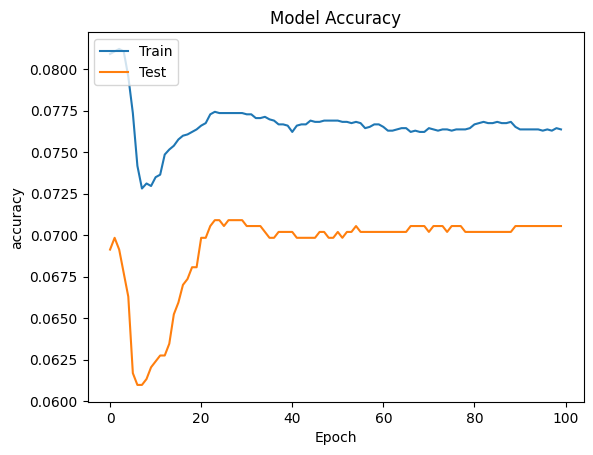

In [20]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

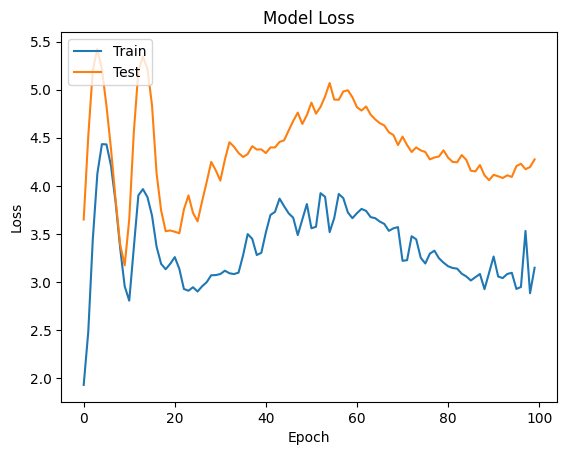

In [21]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()